In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

/opt/conda/envs/eda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
train_data = pd.read_csv("../dataset/train/train.csv")
test_data = pd.read_csv("../dataset/test/test_data.csv")

# Subject, Object Entities

In [4]:
subject_type = []
object_type = []

for i,j in zip(train_data['subject_entity'], train_data['object_entity']):
    subject_dict, object_dict = eval(i), eval(j)

    subject_type.append(f"[S:{subject_dict['type']}]")
    object_type.append(f"[O:{object_dict['type']}]")

    subject_type.append(f"[/S:{subject_dict['type']}]")
    object_type.append(f"[/O:{object_dict['type']}]")

print(set(subject_type))
print(set(object_type))

{'[S:ORG]', '[/S:ORG]', '[/S:PER]', '[S:PER]'}
{'[O:NOH]', '[O:PER]', '[O:DAT]', '[O:ORG]', '[/O:ORG]', '[O:LOC]', '[/O:POH]', '[/O:DAT]', '[/O:LOC]', '[/O:NOH]', '[O:POH]', '[/O:PER]'}


In [5]:
subject_type = []
object_type = []

for i,j in zip(test_data['subject_entity'], test_data['object_entity']):
    subject_dict, object_dict = eval(i), eval(j)

    subject_type.append(f"[S:{subject_dict['type']}]")
    object_type.append(f"[O:{object_dict['type']}]")

    subject_type.append(f"[/S:{subject_dict['type']}]")
    object_type.append(f"[/O:{object_dict['type']}]")

print(set(subject_type))
print(set(object_type))

{'[S:LOC]', '[/S:LOC]', '[S:PER]', '[S:ORG]', '[/S:ORG]', '[/S:PER]'}
{'[O:NOH]', '[O:DAT]', '[O:PER]', '[O:ORG]', '[/O:POH]', '[/O:ORG]', '[O:LOC]', '[/O:DAT]', '[/O:LOC]', '[/O:NOH]', '[O:POH]', '[/O:PER]'}


# Split train, valid dataset

In [132]:
train_split, valid_split = train_test_split(train_data, test_size=0.1, random_state=0, stratify=train_data[['label']])
train_split.to_csv("./train_split_v1.csv")
valid_split.to_csv("./valid_split_v1.csv")
print('num of train_split', len(train_split))
print('num of test_split', len(valid_split))

num of train_split 29223
num of test_split 3247


In [134]:
train_split['label'].value_counts()


label
no_relation                            8581
org:top_members/employees              3856
per:employee_of                        3216
per:title                              1893
org:member_of                          1679
org:alternate_names                    1188
per:origin                             1111
org:place_of_headquarters              1075
per:date_of_birth                      1017
per:alternate_names                     901
per:spouse                              716
per:colleagues                          481
per:parents                             468
org:founded                             405
org:members                             378
per:date_of_death                       376
org:product                             342
per:children                            274
per:place_of_residence                  174
per:other_family                        171
per:place_of_birth                      149
org:founded_by                          139
per:product               

In [130]:
valid_split['label'].value_counts()

label
no_relation                            953
org:top_members/employees              428
per:employee_of                        357
per:title                              210
org:member_of                          187
org:alternate_names                    132
per:origin                             123
org:place_of_headquarters              120
per:date_of_birth                      113
per:alternate_names                    100
per:spouse                              79
per:colleagues                          53
per:parents                             52
org:founded                             45
per:date_of_death                       42
org:members                             42
org:product                             38
per:children                            30
per:place_of_residence                  19
per:other_family                        19
per:place_of_birth                      17
org:founded_by                          16
per:product                             14
per:s

# Utility Functions

In [57]:
def set_difference(df_a, df_b):
    outer_join = pd.merge(df_a, df_b, how='outer', indicator=True)
    diff_set = outer_join.query('_merge=="left_only"').drop(columns='_merge')
    
    return diff_set

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    
    return percentile_

def get_columns(data, index, columns):
    target = data[data['id']==index]

    return target[columns]

model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')


# 0. EDA Summary

### Train Data

In [107]:
# colums => (sentence / subject / object / label)
print("[TRAIN DATA]")
print("total num of data =", len(train_data))
print("unique sentences 개수 =", train_data['sentence'].nunique())
print("label 개수 =", train_data['label'].nunique())

print("sentence가 중복되는 데이터 수 =", \
      sum(train_data.duplicated(keep=False, subset=['sentence'])))

print("ssol이 완전히 일치하는 데이터 수 (ex) 1 1 3 3 4 이면 1, 3 두개로 카운트) =", \
      sum(train_data.duplicated(subset=['sentence', 'subject_entity', 'object_entity', 'label']))) # 제거해도 무방

print("sso가 중복되는 데이터 수, (ex_ 1 1 3 이면 1 1 두개로 카운트) =", \
      sum(train_data.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])))


sub_sso_ssol = set_difference(train_data[train_data.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])],\
                              train_data[train_data.duplicated(subset=['sentence', 'subject_entity', 'object_entity', 'label'])])
dup_sso_sub_sso_ssol = sub_sso_ssol[sub_sso_ssol.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])]
print("sso가 일치하는데 label이 다른 데이터 수 =", sum(sub_sso_ssol.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])))# 어느 label이 정답인지 판단하기 어렵다, 그냥 둔다

print("word level 문장 길이(95 percentile) =",\
      train_data['sentence'].apply(lambda x: len(x.split(' '))).agg([percentile(0.95)]).values[0])

print("token level 문장 길이(95 percentile) =",\
      train_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids'])).agg([percentile(0.95)]).values[0])


[TRAIN DATA]
total num of data = 32470
unique sentences 개수 = 28803
label 개수 = 30
sentence가 중복되는 데이터 수 = 7090
ssol이 완전히 일치하는 데이터 수 (ex) 1 1 3 3 4 이면 1, 3 두개로 카운트) = 42
sso가 중복되는 데이터 수, (ex_ 1 1 3 이면 1 1 두개로 카운트) = 93
sso가 일치하는데 label이 다른 데이터 수 = 10
word level 문장 길이(95 percentile) = 41.0
token level 문장 길이(95 percentile) = 101.0


### Test Data

In [109]:
# colums => (sentence / subject / object / label)
print("[TEST DATA]")
print("total num of data =", len(test_data))
print("unique sentences 개수 =", test_data['sentence'].nunique())
print("label 개수 =", test_data['label'].nunique())

print("sentence가 중복되는 데이터 수 =", \
      sum(test_data.duplicated(keep=False, subset=['sentence'])))

print("sso가 중복되는 데이터 수, (ex_ 1 1 3 이면 1 1 두개로 카운트) =", \
      sum(test_data.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])))

print("word level 문장 길이(95 percentile) =",\
      test_data['sentence'].apply(lambda x: len(x.split(' '))).agg([percentile(0.95)]).values[0])

print("token level 문장 길이(95 percentile) =",\
      test_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids'])).agg([percentile(0.95)]).values[0])


[TEST DATA]
total num of data = 7765
unique sentences 개수 = 7764
label 개수 = 1
sentence가 중복되는 데이터 수 = 2
sso가 중복되는 데이터 수, (ex_ 1 1 3 이면 1 1 두개로 카운트) = 0
word level 문장 길이(95 percentile) = 39.0
token level 문장 길이(95 percentile) = 93.0


# 1. Train/Test dataset overview

In [4]:
train_data.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia


In [5]:
test_data.head()

,id,sentence,subject_entity,object_entity,label,source
0,0,지난 15일 MBC '탐사기획 스트레이트'가 이 사실을 보도했다.,"{'word': 'MBC', 'start_idx': 7, 'end_idx': 9, ...","{'word': '탐사기획 스트레이트', 'start_idx': 12, 'end_i...",100,wikitree
1,1,사랑스러운 ‘프린세스 프링’의 이름은 봄의 공주님: Princess(s)Pring이...,"{'word': '프린세스 프링', 'start_idx': 7, 'end_idx':...","{'word': '공주', 'start_idx': 84, 'end_idx': 85,...",100,wikipedia
2,2,"한편, 본인(이근안)을 모델로 한 MBC 특집드라마 가 1995년 6.25 특집극으...","{'word': '경찰', 'start_idx': 121, 'end_idx': 12...","{'word': '1995년', 'start_idx': 31, 'end_idx': ...",100,wikipedia
3,3,정창손은 김질과 같이 대궐로 달려가 고변하며 '신은 실로 모르고 김질만 혼자 참여하...,"{'word': '세조', 'start_idx': 78, 'end_idx': 79,...","{'word': '정창손', 'start_idx': 0, 'end_idx': 2, ...",100,wikipedia
4,4,"당시 민주당 이진련 시의원은 권영진 시장에게 ""긴급 생계자금을 왜 현금으로 지원하지...","{'word': '민주당', 'start_idx': 3, 'end_idx': 5, ...","{'word': '권영진', 'start_idx': 16, 'end_idx': 18...",100,wikitree


In [12]:
print(f"학습 데이터 개수: {len(train_data)}")
print(f"평가 데이터 개수: {len(test_data)}")

학습 데이터 개수: 32470
평가 데이터 개수: 7765


### 결측치 여부 확인

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32470 entries, 0 to 32469
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32470 non-null  int64 
 1   sentence        32470 non-null  object
 2   subject_entity  32470 non-null  object
 3   object_entity   32470 non-null  object
 4   label           32470 non-null  object
 5   source          32470 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7765 entries, 0 to 7764
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7765 non-null   int64 
 1   sentence        7765 non-null   object
 2   subject_entity  7765 non-null   object
 3   object_entity   7765 non-null   object
 4   label           7765 non-null   int64 
 5   source          7765 non-null   object
dtypes: int64(2), object(4)
memory usage: 364.1+ KB


# 2. label 별 분포 

micro F1 score -> no_relation 을 제외한 샘플이 가장 많은 클래스에 가장 많은 가중치를 부여한다.

In [15]:
# label 의 개수
print(f"학습 데이터의 label 개수: {len(train_data['label'].unique())}")
print(f"평가 데이터의 label (100으로 임의 표현되어 가려져있다.) : {len(test_data['label'].unique())}")

학습 데이터의 label 개수: 30
평가 데이터의 label (100으로 임의 표현되어 가려져있다.) : 1


In [16]:
train_data['label'].value_counts()

label
no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
per:colleagues                          534
per:parents                             520
org:founded                             450
org:members                             420
per:date_of_death                       418
org:product                             380
per:children                            304
per:place_of_residence                  193
per:other_family                        190
per:place_of_birth                      166
org:founded_by                          155
per:product               

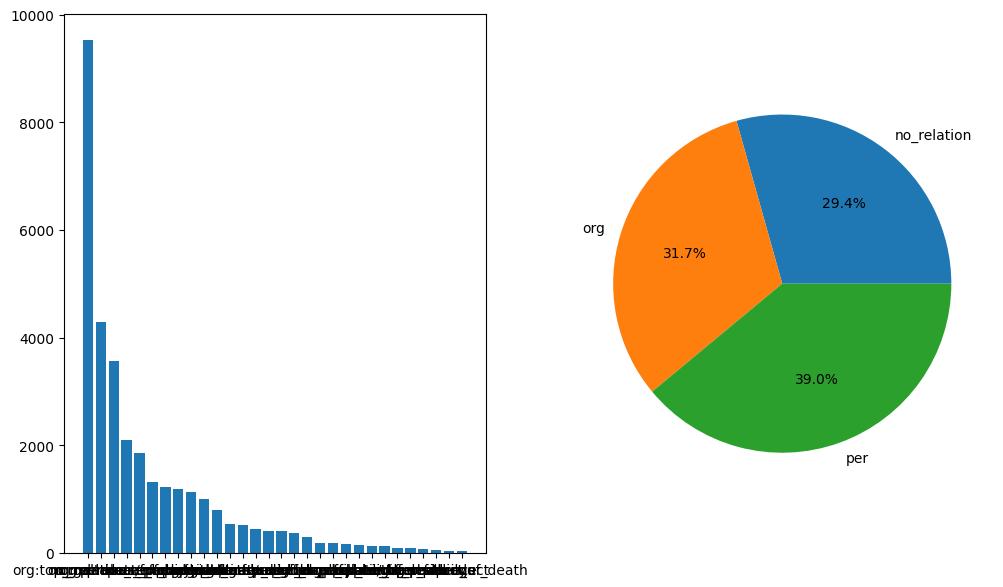

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].bar(train_data['label'].unique(), train_data['label'].value_counts())

labels = {'no_relation': 0, 'org': 0, 'per': 0}
for label in train_data['label']:
  if label != 'no_relation':
    labels[label[:3]] += 1
  else:
    labels[label] += 1

axes[1].pie([num/32470 for num in labels.values()],labels=labels.keys(), autopct='%.1f%%')

plt.show()

# 3. source 별 분포 

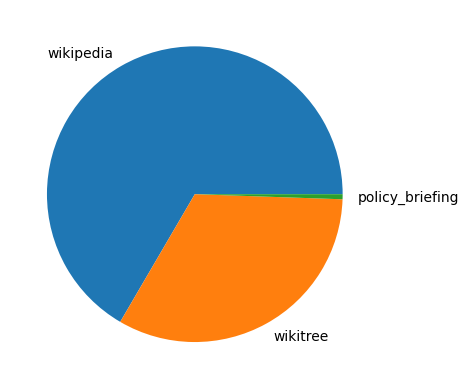

In [5]:
plt.pie(train_data['source'].value_counts(),labels=train_data['source'].unique())
plt.show()

# 4. Sentence Length

### 어절 단위 문장 길이 분석, word level sentence length

In [24]:
train_data['len'] = train_data['sentence'].apply(lambda x: len(x.split(' ')))
test_data['len'] = test_data['sentence'].apply(lambda x: len(x.split(' ')))

print('Train Data\n', train_data.agg({'len':['min', 'max', 'mean']}))
print()
print('Test Data\n', test_data.agg({'len':['min', 'max', 'mean']}))

Train Data
              len
min     3.000000
max   108.000000
mean   20.641423

Test Data
             len
min    3.000000
max   99.000000
mean  20.455892


len
(10, 20]     0.473018
(20, 30]     0.265355
(0, 10]      0.118462
(30, 40]     0.092712
(40, 50]     0.031571
(50, 60]     0.011397
(60, 70]     0.004435
(70, 80]     0.001786
(80, 90]     0.000986
(90, 100]    0.000277
Name: proportion, dtype: float64


<Axes: xlabel='len'>

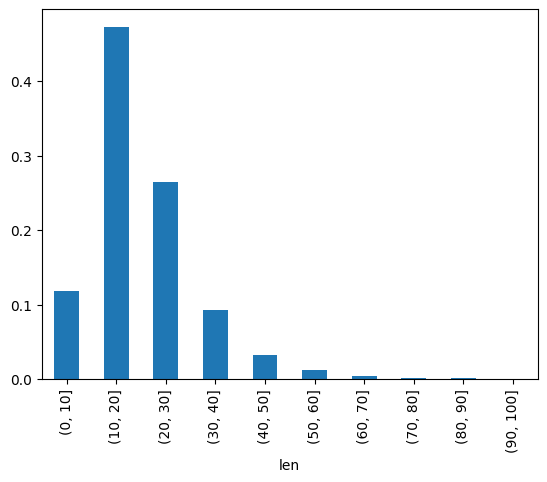

In [27]:
bins = list(range(0, 108, 10))
sentence_len_categories = pd.cut(train_data["len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

len
(10, 20]    0.463035
(20, 30]    0.275374
(0, 10]     0.120428
(30, 40]    0.101494
(40, 50]    0.027821
(50, 60]    0.008372
(60, 70]    0.002705
(70, 80]    0.000386
(80, 90]    0.000386
Name: proportion, dtype: float64


<Axes: xlabel='len'>

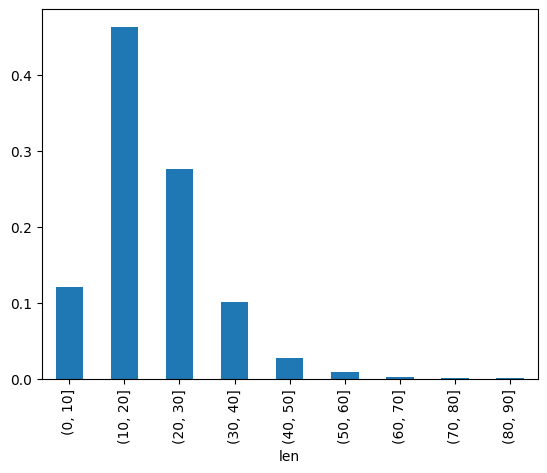

In [28]:
bins = list(range(0, 99, 10))
sentence_len_categories = pd.cut(test_data["len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

### 토큰 단위 문장 길이 분석, Token level sentence length

In [30]:
model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [31]:
train_data['token_len'] = train_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids']))
test_data['token_len'] = test_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [32]:
print(train_data.agg({'token_len':['min', 'max', 'mean']}))
print(test_data.agg({'token_len':['min', 'max', 'mean']}))

       token_len
min     9.000000
max   231.000000
mean   52.958608
      token_len
min        12.0
max       223.0
mean       51.2


token_len
(40, 60]      0.358179
(20, 40]      0.331752
(60, 80]      0.171867
(80, 100]     0.067854
(100, 120]    0.028306
(0, 20]       0.020020
(120, 140]    0.012782
(140, 160]    0.004712
(160, 180]    0.002649
(180, 200]    0.001109
(200, 220]    0.000770
Name: proportion, dtype: float64


<Axes: xlabel='token_len'>

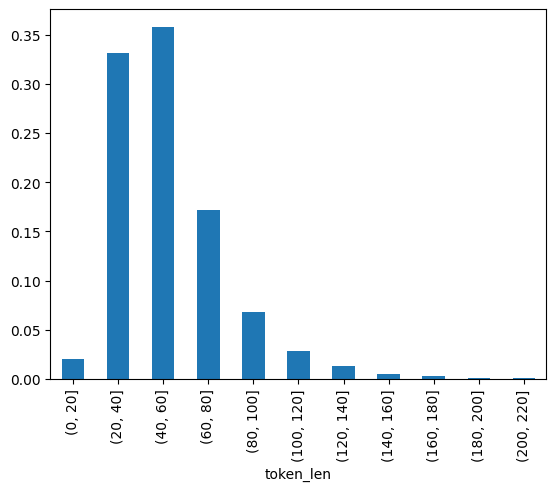

In [33]:
bins = list(range(0, 231, 20))
sentence_len_categories = pd.cut(train_data["token_len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

token_len
(20, 40]      0.347244
(40, 60]      0.339001
(60, 80]      0.179933
(80, 100]     0.067620
(0, 20]       0.030010
(100, 120]    0.023828
(120, 140]    0.007470
(140, 160]    0.003478
(180, 200]    0.000773
(160, 180]    0.000644
(200, 220]    0.000000
Name: proportion, dtype: float64


<Axes: xlabel='token_len'>

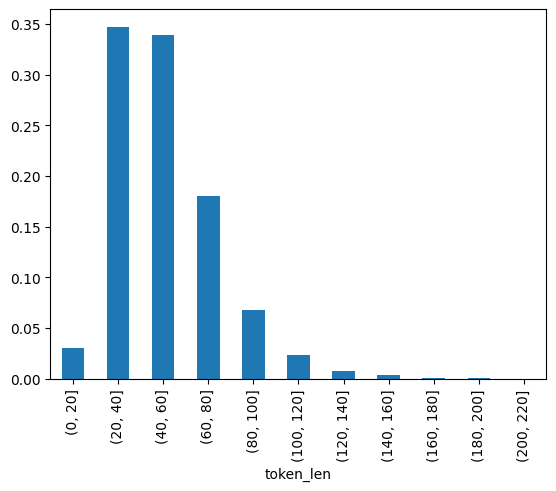

In [34]:
bins = list(range(0, 223, 20))
sentence_len_categories = pd.cut(test_data["token_len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

# 5. 중복 sentence

### 총 32470개의 데이터중에 sentence 중복을 제외하면 28803개의 문장이 있다.
동일한 sentence를 가지고 서로 다른 label 혹은 entity를 적용하고 있음을 나타낸다.

In [35]:
train_data.nunique()

id                32470
sentence          28803
subject_entity    26340
object_entity     25704
label                30
source                3
len                  95
token_len           207
dtype: int64

In [36]:
test_data.nunique()

id                7765
sentence          7764
subject_entity    6758
object_entity     7162
label                1
source               3
len                 73
token_len          153
dtype: int64

In [51]:
def duplicated(data, subset, keep=False):
    return data.duplicated(keep=keep, subset=subset)

In [52]:
print(f'sentence 가 중복되는 데이터의 수: {sum(duplicated(train_data, ["sentence"]))}')
print(f'sentence, subject_entity 와 object_entity 가 동일한 데이터의 수: {sum(duplicated(train_data,["sentence", "subject_entity", "object_entity"]))}')
print(f'sentence, subject-entity, object_entity 와 label 이 동일한 데이터의 수: {sum(duplicated(train_data, ["sentence","subject_entity","object_entity", "label"]))}')

sentence 가 중복되는 데이터의 수: 7090
sentence, subject_entity 와 object_entity 가 동일한 데이터의 수: 93
sentence, subject-entity, object_entity 와 label 이 동일한 데이터의 수: 84


In [53]:
sso = train_data[duplicated(train_data,["sentence", "subject_entity", "object_entity"])]
ssol = sso_indcies = train_data[duplicated(train_data,["sentence", "subject_entity", "object_entity", "label"])]

### Train Data : [sentence, subject_entity, object_entity, label] 까지 완벽히 동일한 데이터

In [54]:
ssol.sort_values('sentence')

,id,sentence,subject_entity,object_entity,label,source,len
22090,22090,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia,14
9618,9618,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia,14
25368,25368,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia,14
2500,2500,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia,14
3547,3547,2010년 10월 15일 전라북도청을 방문한 맹형규 행정안전부 장관은 도내 지자체간...,"{'word': '전라북도청', 'start_idx': 14, 'end_idx': ...","{'word': '행정안전부', 'start_idx': 29, 'end_idx': ...",no_relation,wikipedia,54
...,...,...,...,...,...,...,...
27325,27325,펀치넬로는 10cm의 권정열이 피처링으로 참여한 '미안해서 미안해'로 무대에 올랐다.,"{'word': '권정열', 'start_idx': 12, 'end_idx': 14...","{'word': '10cm', 'start_idx': 6, 'end_idx': 9,...",per:employee_of,wikitree,9
14658,14658,함연지는 함영준 오뚜기 회장의 장녀다.,"{'word': '오뚜기', 'start_idx': 9, 'end_idx': 11,...","{'word': '함영준', 'start_idx': 5, 'end_idx': 7, ...",org:top_members/employees,wikitree,5
6936,6936,함연지는 함영준 오뚜기 회장의 장녀다.,"{'word': '오뚜기', 'start_idx': 9, 'end_idx': 11,...","{'word': '함영준', 'start_idx': 5, 'end_idx': 7, ...",org:top_members/employees,wikitree,5
20898,20898,화려한 재기를 뒤로하고 고(故) 안재환에게 돈을 빌려줬다는 루머로 마음고생을 하던 ...,"{'word': '최진실', 'start_idx': 46, 'end_idx': 48...","{'word': '2008년 10월 2일', 'start_idx': 51, 'end...",per:date_of_death,wikitree,21


### Train Data : [sentence, subject_entity, object_entity] 까지 완벽히 동일한 데이터

In [55]:
sso.sort_values('sentence')

,id,sentence,subject_entity,object_entity,label,source,len
9618,9618,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia,14
22090,22090,"1959-60 시즌 이후의 알파 에트니키 / 수페르리가 엘라다, 그리스 컵, 그리고...","{'word': '수페르리가 엘라다', 'start_idx': 25, 'end_id...","{'word': '그리스', 'start_idx': 36, 'end_idx': 38...",no_relation,wikipedia,14
25368,25368,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia,14
2500,2500,2001년 4월 민주국민당 김윤환 의원과 민주당 의원 사이의 정책 연합과 관련한 통...,"{'word': '민주국민당', 'start_idx': 9, 'end_idx': 1...","{'word': '민주당', 'start_idx': 23, 'end_idx': 25...",no_relation,wikipedia,14
255,255,2010년 10월 15일 전라북도청을 방문한 맹형규 행정안전부 장관은 도내 지자체간...,"{'word': '전라북도청', 'start_idx': 14, 'end_idx': ...","{'word': '행정안전부', 'start_idx': 29, 'end_idx': ...",no_relation,wikipedia,54
...,...,...,...,...,...,...,...
4212,4212,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:members,wikitree,23
6936,6936,함연지는 함영준 오뚜기 회장의 장녀다.,"{'word': '오뚜기', 'start_idx': 9, 'end_idx': 11,...","{'word': '함영준', 'start_idx': 5, 'end_idx': 7, ...",org:top_members/employees,wikitree,5
14658,14658,함연지는 함영준 오뚜기 회장의 장녀다.,"{'word': '오뚜기', 'start_idx': 9, 'end_idx': 11,...","{'word': '함영준', 'start_idx': 5, 'end_idx': 7, ...",org:top_members/employees,wikitree,5
4248,4248,화려한 재기를 뒤로하고 고(故) 안재환에게 돈을 빌려줬다는 루머로 마음고생을 하던 ...,"{'word': '최진실', 'start_idx': 46, 'end_idx': 48...","{'word': '2008년 10월 2일', 'start_idx': 51, 'end...",per:date_of_death,wikitree,21


### sso, ssol의 차집합 구하기 (동일한 sentence, sub/obj entity에서 label이 다른 경우)

In [56]:
# sso 와 ssol 의 차집합 구하기
df = pd.merge(sso, ssol, how='outer', indicator=True)
df.query('_merge=="left_only"').drop(columns='_merge').sort_values('sentence')

,id,sentence,subject_entity,object_entity,label,source,len
17,6749,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",no_relation,wikipedia,14
35,12829,대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량...,"{'word': '대한항공', 'start_idx': 0, 'end_idx': 3,...","{'word': '조양호', 'start_idx': 9, 'end_idx': 11,...",org:top_members/employees,wikipedia,14
22,8364,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",no_relation,wikitree,18
92,32299,배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우...,"{'word': '정복동', 'start_idx': 15, 'end_idx': 17...","{'word': '김병철', 'start_idx': 3, 'end_idx': 5, ...",per:alternate_names,wikitree,18
33,11511,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",per:place_of_residence,wikitree,17
57,22258,"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나...","{'word': '배트맨', 'start_idx': 16, 'end_idx': 18...","{'word': '고담시', 'start_idx': 24, 'end_idx': 26...",no_relation,wikitree,17
7,3296,"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악...","{'word': '강태환', 'start_idx': 62, 'end_idx': 64...","{'word': '색소폰', 'start_idx': 58, 'end_idx': 60...",per:title,wikitree,22
10,4212,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:members,wikitree,23
64,25094,한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 ...,"{'word': '전라남도', 'start_idx': 3, 'end_idx': 6,...","{'word': '여수시', 'start_idx': 26, 'end_idx': 28...",org:place_of_headquarters,wikitree,23


# 6. 중복 sentence case study

### Train Data : Case1. sentence는 동일한데 sub/obj 혹은 label이 다른 경우

"대한항공은 5일 조양호 회장의 3자녀가 보유한 싸이버스카이 주식 9만9900주 전량을 63억 원에 취득한다고 밝혔다."

id: 6749, 7276, 12829

In [58]:
target_columns = ['subject_entity', 'object_entity', 'label']

display(get_columns(train_data, 6749, target_columns).values)
display(get_columns(train_data, 7276, target_columns).values)
display(get_columns(train_data, 12829, target_columns).values)

array([["{'word': '대한항공', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        "{'word': '조양호', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        'no_relation']], dtype=object)

array([["{'word': '조양호', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        "{'word': '대한항공', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        'no_relation']], dtype=object)

array([["{'word': '대한항공', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        "{'word': '조양호', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        'org:top_members/employees']], dtype=object)

'org:top_members/employees' 는 no_relation 을 제외했을 때 가장 데이터가 많은 label 이다.

### Train Data : Case2. sentence와 obj/sub는 동일한데 label이 다른 경우

"이날 프로그램 공개에서는 전북영산작법보존회와 김명신‧정상희의 사제동행 판소리, 관악 명인 대금 원장현, 색소폰 강태환의 무대를 선보이며 올해 축제에 대한 기대감을 한껏 끌어 올렸다."

id: 277, 3296, 10202

In [59]:
display(get_columns(train_data, 277, target_columns).values)
display(get_columns(train_data, 10202, target_columns).values)
display(get_columns(train_data, 3296, target_columns).values)

array([["{'word': '강태환', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': '색소폰', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'no_relation']], dtype=object)

array([["{'word': '강태환', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': '색소폰', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'no_relation']], dtype=object)

array([["{'word': '강태환', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': '색소폰', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'per:title']], dtype=object)

"배우 김병철 씨가 연기하는 정복동은 천리마마트를 망하게 하기 위해 여러 계획을 세우지만 반대로 하는 일마다 대박을 치는 캐릭터이다."

id: 8364, 32299

In [60]:
display(get_columns(train_data, 8364, target_columns).values)
display(get_columns(train_data, 32299, target_columns).values)

array([["{'word': '정복동', 'start_idx': 15, 'end_idx': 17, 'type': 'PER'}",
        "{'word': '김병철', 'start_idx': 3, 'end_idx': 5, 'type': 'PER'}",
        'no_relation']], dtype=object)

array([["{'word': '정복동', 'start_idx': 15, 'end_idx': 17, 'type': 'PER'}",
        "{'word': '김병철', 'start_idx': 3, 'end_idx': 5, 'type': 'PER'}",
        'per:alternate_names']], dtype=object)

"영화 '버즈 오브 프레이'는 배트맨이 없는 고담시에서 할리퀸, 헌트리스, 블랙 카나리가 힘을 합쳐 한 소녀를 구한다는 이야기다."

id: 11511, 22258

In [62]:
display(get_columns(train_data, 11511, target_columns).values)
display(get_columns(train_data, 22258, target_columns).values)

array([["{'word': '배트맨', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",
        "{'word': '고담시', 'start_idx': 24, 'end_idx': 26, 'type': 'LOC'}",
        'per:place_of_residence']], dtype=object)

array([["{'word': '배트맨', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",
        "{'word': '고담시', 'start_idx': 24, 'end_idx': 26, 'type': 'LOC'}",
        'no_relation']], dtype=object)

### Train Data : Case3. sentence는 동일한데 obj/sub entity, label 이 다른 경우

"한편 전라남도는 최근 확진자가 발생한 순천시와 여수시에 마스크를 각각 2만장씩 총 4만장 지원했으며, 이날 확진자가 나온 광양시에도 현장상황을 감안해 적정 물량을 지원키로 했다."

id: 4212, 25096

In [63]:
display(get_columns(train_data, 4212, target_columns).values)
display(get_columns(train_data, 25096, target_columns).values)

array([["{'word': '전라남도', 'start_idx': 3, 'end_idx': 6, 'type': 'ORG'}",
        "{'word': '여수시', 'start_idx': 26, 'end_idx': 28, 'type': 'LOC'}",
        'org:members']], dtype=object)

array([["{'word': 'MBC충북', 'start_idx': 18, 'end_idx': 22, 'type': 'ORG'}",
        "{'word': '충청북도', 'start_idx': 36, 'end_idx': 39, 'type': 'POH'}",
        'org:place_of_headquarters']], dtype=object)

# 3. 특수문자 

한글 외에도 특수 알파벳, 한자, 일본어, 아랍어, 로마자, 키릴 문자, 수학 단위 등 발견

일부 문자의 경우 entity 에도 포함이 되어 있었다

한글 자음만 있는 경우도 있으나, Lv.1 때와 다르게 이름을 초성으로 표현한 경우

entity 에 단어의 index 도 같이 표현되어 있기 때문에 data cealning 은 신중하게 하는 게 좋아 보인다.

In [106]:
sentences = train_data['sentence']
is_special_character = re.compile('[^,~()\'\"/_;:*$?&%<>!.A-Za-z0-9ㄱ-ㅎ가-힣一-龥ぁ-んァ-ン\s]')
# is_special_character = re.compile('[^()$?%!A-Za-z0-9ㄱ-ㅎ가-힣]')

special_characters = set()

for sentence in sentences:
  # if len(is_special_character.findall(sentence)) != 0 :
    # print(sentence)
  for char in is_special_character.findall(sentence):
    special_characters.add(char)

print(special_characters)
print(len(special_characters))

{'ي', 'š', 'ж', '|', ']', 'ậ', 'П', 'ث', '́', 'Α', '」', 'न', 'ū', 'Ж', '↔', '⁺', '्', 'ه', 'Γ', 'ợ', 'ˈ', 'ΐ', 'ا', 'б', 'û', 'ı', 'म', 'п', 'Ⅱ', '=', '`', '〈', 'ㆍ', '⋅', 'ö', 'Ζ', '１', '∼', '★', '®', 'ح', '˹', '《', 'د', 'τ', 'Ç', '｢', 'ч', 'É', 'ц', 'ạ', 'ü', 'ہ', 'Κ', 'ς', 'С', '／', 'Ǧ', '»', '\uf09e', '⅔', 'è', '”', '※', 'ȳ', '⌜', 'ر', 'ú', 'р', 'é', 'ő', '‘', '⌟', 'ℓ', 'ع', '）', '㎏', '㎡', 'و', '∙', 'Д', 'о', 'İ', 'σ', 'π', '℃', 'υ', '＇', 'ύ', '≪', 'ß', 'γ', 'ज', 'Ⓐ', 'χ', '䄄', 'ì', 'ы', 'й', '⟪', '“', 'я', 'ك', 'Č', 'ο', '𑀥', 'А', '-', 'И', 'ف', '㈜', '≫', '×', 'ả', '°', 'ヶ', 'І', 'ی', '𑀕', 'ी', 'м', 'ç', 'ά', '》', 'ã', 'ር', 'Ⅰ', '？', 'В', 'ш', 'Ś', 'έ', 'Ч', 'ό', 'ह', 'Ö', 'ڤ', 'Β', 'ư', 'у', 'э', '[', 'ğ', 'ø', '⟫', 'ና', 'ب', 'ņ', '․', '：', '}', 'κ', '％', 'ễ', '—', 'ኔ', 'ɒ', 'Á', 'ظ', 'ن', 'е', '़', 'ć', 'ｍ', '⸱', '•', 'ô', 'ầ', 'ş', '▲', 'н', '□', '⅓', 'л', 'ʒ', '㎜', 'ơ', 'द', '’', '』', 'å', '▵', '𑀫', 'α', 'ä', 'â', '☏', 'Ú', 'Ⅲ', 'ा', 'ồ', 'ድ', '○', 'ν', 'К', 'к', '―', 'д', 'ت',

In [105]:
s = '아우세클리스 ((Auseklis)(Auseklis) ("Auseklītis", " Ausekliņš ", "Ausekliņis", "Ausekleņis" 도 "Ausekliņa", "Auseklītis")) 라트비아 신화와 밀접하게 연결된 여명의 신이다.'
# s = '한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등록 마감 결과, 강석호(3선·경북 영양·영덕·봉화·울진)-이장우(재선·대전 동구), 유기준(4선·부산 서구·동구)-박성중(초선·서울 서초을), 김선동(재선·서울 도봉을)-김종석(초선·비례), 심재철(5선·경기 안양시동안구을)-김재원(3선·경북 상주·군위·의성·청송) 등 4개 조가 등록했다고 밝혔다.'
model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
print(tokenizer.decode(tokenizer.encode(s)))

[CLS] 아우세클리스 ( ( Auseklis ) ( Auseklis ) ( " [UNK] ", " [UNK] ", " [UNK] ", " [UNK] " 도 " [UNK] ", " [UNK] " ) ) 라트비아 신화와 밀접하게 연결된 여명의 신이다. [SEP]
